# YouTube trending videos

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from helpers.files import load_csv

In [ ]:
publish_time_counts = videos["trending_date"].value_counts()
publish_time_counts = publish_time_counts.rename_axis("trending_date").reset_index(name="count")

print(publish_time_counts)
plt.bar(pd.to_datetime(publish_time_counts["trending_date"], format="%y.%d.%m"), publish_time_counts["count"])
plt.show()

gb_videos, us_videos = load_csv("clustering_data")
videos = pd.concat([gb_videos, us_videos])
videos = videos[videos["new_category_id"].notna()]
print(len(videos))

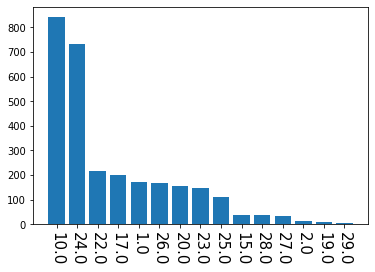

In [3]:
attr_c = gb_videos["new_category_id"].value_counts()
attr_c = attr_c.rename_axis("new_category_id").reset_index(name="count")
labels = [str(i) for i in attr_c["new_category_id"]]
plt.bar(labels, attr_c["count"])
plt.xticks(rotation=270, fontsize=15)
plt.show()

## Etap 5 - Zbieranie danych nie-trending

### Skrypt do zbierania danych trending

Pierwszym krokiem, który został wykonany w ramach tego etapu było
zapoznanie się z oryginalnym skryptem do pobierania danych „trending".
Skrypt jest dostępny w repozytorium [Trending-Youtube-Scraper](https://github.com/mitchelljy/Trending-YouTube-Scraper).

Oryginalny skrypt do pobierania danych -> w jego
kontekscie można opisać dlaczego tak pobieramy

### Pomysł na pobranie danych nie trending

- Podział okresu 11.2017-07.2018 na 4 podokresy
- Zbieranie danych „proporcjami” wystąpień kategorii podobnymi do oryginalnych
- Filtrowanie filmów trending
- Filtrowanie ewentualnych powtórzeń
- Uzupełnianie statystyk

Testowe dane

### Wczytanie danych trending

In [ ]:
gb_videos, us_videos = load_csv("ped3_data")
trending_videos = pd.concat([gb_videos, us_videos])

### Wczytanie danych nie trending

In [ ]:
gb_non_videos, us_non_videos = load_csv("ped5_full_data")
non_trending_videos = pd.concat([gb_non_videos, us_non_videos])

In [4]:
gb_downloaded, us_downloaded = load_csv("ped5_full_data")
videos_d = pd.concat([gb_downloaded, us_downloaded])


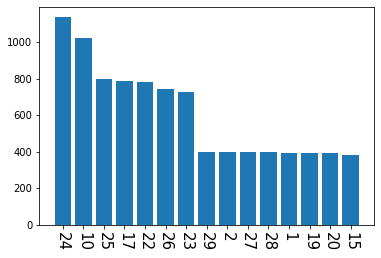

              publish_time  count
0     2018-02-22T13:43:29Z     20
1     2018-02-22T13:43:30Z     12
2     2018-06-26T06:57:35Z      8
3     2018-01-26T05:00:01Z      8
4     2018-02-17T02:45:00Z      8
...                    ...    ...
7106  2017-11-16T13:30:00Z      1
7107  2018-06-06T10:28:04Z      1
7108  2018-02-27T11:30:00Z      1
7109  2018-01-26T18:42:13Z      1
7110  2017-12-17T01:06:46Z      1

[7111 rows x 2 columns]


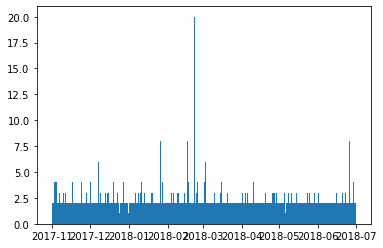

In [7]:
attr_c = videos_d["category_id"].value_counts()
attr_c = attr_c.rename_axis("category_id").reset_index(name="count")
labels = [str(i) for i in attr_c["category_id"]]
plt.bar(labels, attr_c["count"])
plt.xticks(rotation=270, fontsize=15)
plt.show()


publish_time_counts = videos_d["publish_time"].value_counts()
publish_time_counts = publish_time_counts.rename_axis("publish_time").reset_index(name="count")

print(publish_time_counts)
plt.bar(pd.to_datetime(publish_time_counts["publish_time"], format="%Y-%m-%dT%H:%M:%SZ"), publish_time_counts["count"])
plt.show()
